# Livelike Basic Usage Demo: Tract/Supertract

- ACS 2014 - 2019 5-Year Estimates
- UP Baseline Constraints: employment, industry, occupation, education
- Knoxville City, TN PUMA (`4701603`)

## Setup

In [1]:
%load_ext watermark
%watermark

Last updated: 2025-03-20T14:44:39.471253-04:00

Python implementation: CPython
Python version       : 3.12.9
IPython version      : 9.0.2

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.3.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit



In [2]:
import pathlib

import geopandas as gpd
import numpy as np
import pandas as pd
from likeness_vitals.vitals import get_censusapikey, match
from pymedm import PMEDM, diagnostics

from livelike import acs, est, homesim

%watermark -w
%watermark -iv

Watermark: 2.5.0

livelike       : 1.4.8.dev3+geea70e8
pymedm         : 2.2.3
geopandas      : 1.0.1
likeness_vitals: 0.1.dev3+g2392110.d20250320
numpy          : 2.2.4
pandas         : 2.2.3



### Read Census API Key

In [3]:
key = get_censusapikey(pathlib.Path("..", ""))

### Create baseline PUMA representation

The `puma` class stores a representation of the PUMA based on ACS constraints. It contains the microdata and block group/tract estimates and standard errors required for P-MEDM.

In [4]:
# target PUMA - Knoxville City, TN
p = "4701603"

In [5]:
# Create baseline PUMA representation
pup = acs.puma(p, target_zone="trt", keep_geo=True, censusapikey=key)

<Axes: >

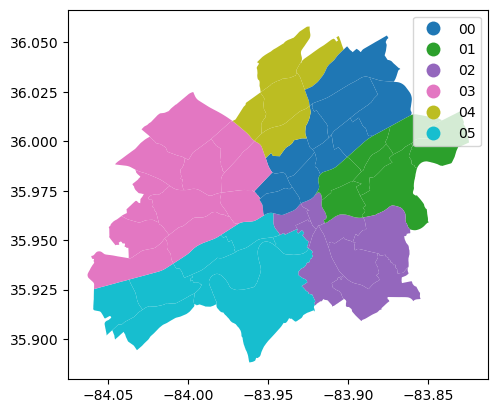

In [6]:
# preview supertracts
pup.geo.plot("super_trt", legend=True)

## Spatial Allocation with P-MEDM

### Create P-MEDM object

**Inputs:**

- ACS vintage year.
- The PUMS household response serial numbers (`serial`).
- The PUMS household sample weights (`wt`)
- Individual-level constraints (`est_ind`)
- Tract and block group level constraints (`est_trt`, `est_bg`)
- Tract and block group level standard errors (`se_trt`, `se_bg`)

In [7]:
pmd = PMEDM(
    pup.year,
    pup.est_ind.index,
    pup.wt,
    pup.est_ind,
    pup.est_g1,
    pup.est_g2,
    pup.se_g1,
    pup.se_g2,
    topo=pup.topo,
)

In [8]:
# Solve P-MEDM problem
pmd.solve()

In [9]:
# objective value
float(pmd.res.state.value)

-0.8900463165564878

### Diagnostics

As a quick diagnostic, we measure the proportion of synthetic constraint estimates fitting the ACS 90% margins of error (MOEs), or the "moe_fit_rate":

In [10]:
diagnostics.moe_fit_rate(pup.est_ind, pup.est_g2, pup.se_g2, pmd.almat)

{'Ycomp':                         constraint   acs         pmedm           err    moe  \
 47093003100             population  2612  2.635399e+03  2.339874e+01  220.0   
 47093007000             population  2891  2.885673e+03  5.326995e+00  416.0   
 47093001700             population  2273  2.327619e+03  5.461902e+01  317.0   
 47093001600             population  2888  2.920194e+03  3.219441e+01  269.0   
 47093001500             population  3520  3.536760e+03  1.675992e+01  391.0   
 ...                            ...   ...           ...           ...    ...   
 47093003700  hht_nonfam_hhsize_7pm     0  1.938366e-12  1.938366e-12   12.0   
 47093002600  hht_nonfam_hhsize_7pm     0  1.401047e-04  1.401047e-04   12.0   
 47093000902  hht_nonfam_hhsize_7pm     4  5.172050e+00  1.172050e+00    7.0   
 47093004404  hht_nonfam_hhsize_7pm     0  2.011444e-06  2.011444e-06   12.0   
 47093007100  hht_nonfam_hhsize_7pm     0  1.681048e-14  1.681048e-14   12.0   
 
              in_moe  
 47093

## Population Synthesis

Use Lovelace and Ballas' (2013) "Truncate, Replicate, Sample" method to create 30 realizations of the residential synthetic population:

In [11]:
hs = homesim.synthesize(
    pmd.almat,
    pup.est_ind,
    pup.est_g2,
    pup.sporder,
    random_state=int(pup.fips),
)
hs

,sim,geoid,count
h_id,,,
2015000000763,0,47093003100,2
2015000010209,0,47093003100,1
2015000013399,0,47093003100,2
2015000014210,0,47093003100,1
2015000016127,0,47093003100,1
...,...,...,...
2019HU1387059,29,47093007100,2
2019HU1389377,29,47093007100,3
2019HU1396943,29,47093007100,4


## Application 1: Creating Agents for `actlike`

For this example, we'll focus on tabulating 10th grade public school students. We will identify matching person-level records from the PUMS by querying the Census Microdata API on two criteria:

- Public School Student {`SCH` : 2}
- Attending 10th Grade {`SCHG` : 12}

We set up our API query by separating these conditions with an `&`, as:

In [12]:
# API query
q1 = "SCH=2&SCHG=12"

In [13]:
seg1_extract = acs.extract_pums_segment_ids(p, "person", q1)

Then, create the agents by merging the extract with our synthetic population (`hs`): 

In [14]:
seg1 = hs.merge(
    seg1_extract.loc[:, ["SERIALNO", "p_id"]], left_on="h_id", right_on="SERIALNO"
)

In [15]:
seg1

,sim,geoid,count,SERIALNO,p_id
0,0,47093003100,1,2015000400808,201500040080802
1,0,47093003100,1,2015000889349,201500088934904
2,0,47093003100,3,2016000064819,201600006481902
3,0,47093003100,2,2016001269073,201600126907303
4,0,47093003100,1,2017000488751,201700048875104
...,...,...,...,...,...
20500,29,47093007100,1,2018HU0647824,2018HU064782404
20501,29,47093007100,5,2018HU1036109,2018HU103610904
20502,29,47093007100,1,2018HU1086716,2018HU108671602
20503,29,47093007100,1,2018HU1283599,2018HU128359902


## Application 2: Tabulating Segments

Sometimes we require more specific criteria to select segments than what is available in our P-MEDM constraints (i.e., occupation class, NAICS code, hours worked). We can fetch additional PUMS variables related to the constraints from the Census Microdata API query and then link them to our synthetic populations.

For this example, we'll estimate the counts of full-time workers in K-12 schools, specifically:

- Employed full time and currently at work (`ESR == 1`)
- Working in elementary or secondary schools (`NAICSP == 6111`)
- In a preschool, kindergarten, primary, or secondary school teaching position (`{OCCP : [2300, 2310, 2320]}`)
- Working 40+ hours per week (`WKHP >= 40`)

Begin by generating the new API query:

In [16]:
q2 = "ESR=1&NAICSP=6111&OCCP=2300:2320&WKHP=40:999"

A `>=` operator does not seem to be availble for CMD API requests, so `40:999` is used in its place.

Now make the API extract:

In [17]:
seg2 = acs.extract_pums_segment_ids(p, "person", q2, censusapikey=key)

This returns a DataFrame containing the household ID (`SERIALNO`) and household structure (`SPORDER`) for each matching respondent in the PUMS:

In [18]:
seg2

,SERIALNO,SPORDER,ESR,NAICSP,OCCP,WKHP,p_id
1,2015000813438,2,1,6111,2310,50,201500081343802
2,2015001251810,1,1,6111,2310,40,201500125181001
3,2015001489659,2,1,6111,2310,40,201500148965902
4,2016000320880,1,1,6111,2320,45,201600032088001
5,2016000962763,1,1,6111,2310,40,201600096276301
...,...,...,...,...,...,...,...
99,2019HU0482936,2,1,6111,2310,40,2019HU048293602
100,2019HU0561641,1,1,6111,2300,50,2019HU056164101
101,2019HU0598017,1,1,6111,2310,50,2019HU059801701
102,2019HU0907532,2,1,6111,2320,45,2019HU090753202


Tabulation:

In [19]:
tab_seg2 = est.tabulate_by_serial(hs, seg2["SERIALNO"], "person")

In [20]:
tab_seg2

sim  geoid      
0    47093000100    27
     47093000800     9
     47093001400     4
     47093001500    58
     47093001600    24
                    ..
29   47093006700    32
     47093006800    16
     47093006900    23
     47093007000     5
     47093007100    54
Length: 1410, dtype: int64

### 2a. Comparing Segment Estimates Across Census Areas

This estimation method is more suited for geodemographic classification.  We'll stick with our K-12 educator segment from the previous example here. 

A necessary first step is to **normalize the estimates** to effectively relate census areas. The normalization procedure estimates the _proportion_ of the segment within each block group.  

This one-liner generates the total block group population and household counts by simulation number:

In [21]:
totalpop = est.tabulate_by_count(hs, pup.est_ind["population"])

In [22]:
totalpop

sim  geoid      
0    47093000100    1515.253663
     47093000800    2056.237540
     47093000901     482.800505
     47093000902     675.879342
     47093001400    1359.165017
                       ...     
29   47093006700    1855.856343
     47093006800    2082.092679
     47093006900    2014.403391
     47093007000    1594.362835
     47093007100    2100.107139
Name: population, Length: 1470, dtype: float64

With `totalpop` in hand, we can then normalize the estimates: 

In [23]:
prop_seg2 = est.to_prop(tab_seg2, totalpop)

In [24]:
prop_seg2

sim  geoid      
0    47093000100    0.017819
     47093000800    0.004377
     47093001400    0.002943
     47093001500    0.026303
     47093001600    0.012894
                      ...   
27   47093000902    0.000000
28   47093000901    0.000000
     47093000902    0.000000
29   47093000901    0.000000
     47093000902    0.000000
Length: 1470, dtype: float64

### 2b. Monte Carlo Estimation

When comparing census areas, it is often more convenient to use estimates that are one-to-one. To achieve this, we can use Monte Carlo estimation to aggregate the simulation-level estimates (as well as gauge uncertainty). 

To generate the Monte Carlo estimates:

In [25]:
mc_prop_seg2 = est.monte_carlo_estimate(prop_seg2)

In [26]:
mc_prop_seg2.head()

,est,se
geoid,,
47093000100,0.017760,0.000047
47093000800,0.004397,0.000014
47093000901,0.000000,0.000000
47093000902,0.000000,0.000000
47093001400,0.002937,0.000007


#### Example 3b: Mapping the Estimates

In [27]:
knox_trt = pup.geo

In [28]:
mc_prop_seg2.index.name = "GEOID"

In [29]:
knox_trt["mc_prop_seg2"] = match(knox_trt, mc_prop_seg2.est)

<Axes: >

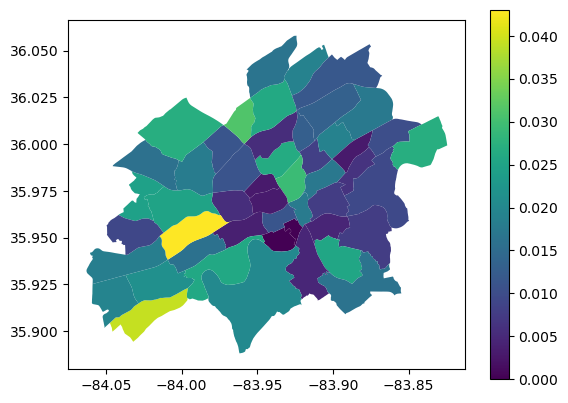

In [30]:
# plot!
knox_trt.plot(column="mc_prop_seg2", legend=True)